In [2]:
import pandas as pd

#import spark
from pyspark.sql import SparkSession
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 ass2 BNPL group 28")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/10 08:36:58 WARN Utils: Your hostname, Rudyletsgo resolves to a loopback address: 127.0.1.1; using 172.25.252.162 instead (on interface eth0)
22/10/10 08:36:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/10 08:36:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/10 08:37:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
## read the merchant data
merchant_info = spark.read.options(header = True).csv('../data/curated/merchant_info_no_fraud.csv')
merchant_tents = merchant_info.where(merchant_info.field == "tent and awning shops")
merchant_jewl = merchant_info.where(merchant_info.field == "jewelry, watch, clock, and silverware shops")
merchant_shoe = merchant_info.where(merchant_info.field == "shoe shops")

# Transform to pandas dataframe
merchant_info = merchant_info.toPandas()
merchant_tents = merchant_tents.toPandas()
merchant_jewl = merchant_jewl.toPandas()
merchant_shoe = merchant_shoe.toPandas()

## convert dataset columns into fesible types
merchant_info[['transaction_count', 'take_rate', 'total_revenue', 'mean_consumer_income', 'fraud_count', 'main_business_area_popu']] \
    = merchant_info[['transaction_count', 'take_rate', 'total_revenue', 'mean_consumer_income', 'fraud_count', 'main_business_area_popu']].apply(pd.to_numeric)

merchant_tents[['transaction_count', 'take_rate', 'total_revenue', 'mean_consumer_income', 'fraud_count', 'main_business_area_popu']] \
    = merchant_tents[['transaction_count', 'take_rate', 'total_revenue', 'mean_consumer_income', 'fraud_count', 'main_business_area_popu']].apply(pd.to_numeric)

merchant_jewl[['transaction_count', 'take_rate', 'total_revenue', 'mean_consumer_income', 'fraud_count', 'main_business_area_popu']] \
    = merchant_jewl[['transaction_count', 'take_rate', 'total_revenue', 'mean_consumer_income', 'fraud_count', 'main_business_area_popu']].apply(pd.to_numeric)

merchant_shoe[['transaction_count', 'take_rate', 'total_revenue', 'mean_consumer_income', 'fraud_count', 'main_business_area_popu']] \
    = merchant_shoe[['transaction_count', 'take_rate', 'total_revenue', 'mean_consumer_income', 'fraud_count', 'main_business_area_popu']].apply(pd.to_numeric)

#merchant_tents = merchant_info.loc[merchant_info['field'] == "tent and awning shops"].copy()
#merchant_jewl = merchant_info.loc[merchant_info['field']  == "jewelry, watch, clock, and silverware shops"].copy()
#merchant_shoe = merchant_info.loc[merchant_info['field'] == "shoe shops"].copy()

### Create score criteria(standard version)

In [4]:
## Manually set the score criteria, could be changed later.
score_criteria = { \
    'transaction_count': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
        'take_rate': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
            'revenue_level': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
                'total_revenue': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
                    'mean_consumer_income': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
                        'fraud_count': {'a':0, 'b': 0, 'c': 0, 'd': 0, 'e': 0}, \
                            'main_business_area_popu': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}}

In [5]:
## store all numeric features into list for use in both Algorithms
featrue_name = list(merchant_info.keys())
featrue_name.remove('merchant_abn')
featrue_name.remove('field')

## Feature Selection

In [6]:
import numpy as np
from sklearn import linear_model

features = pd.get_dummies(merchant_info, prefix=['revenue_level'], columns=['revenue_level'])
features['transaction_count'] = np.log(features['transaction_count'])
features['mean_consumer_income'] = np.log(features['mean_consumer_income'])
features['main_business_area_popu'] = np.log(features['main_business_area_popu'])

X = features[['transaction_count', 'mean_consumer_income', 'main_business_area_popu', 'revenue_level_a', 'revenue_level_b', 'revenue_level_c', 'revenue_level_d', 'revenue_level_e']]
y = np.log(features["take_rate"]*0.01*features['total_revenue'])

regr = linear_model.LinearRegression()
regr.fit(X, y)

print(regr.coef_)

[ 0.57068973 -0.08793658 -0.06883601  1.23503339  0.95980063  0.25778829
 -0.53626589 -1.91635643]


## Mark Algorithm

In [7]:
## Function used to assign continuous features into level (a,b,c,d,e) based on current merchant infomation
## merchant_info (a pd.DataFrame) is the current merchant information that are considered in our ranking system
## feature (a string) is the numeric feature we are working on
## score_criteria (a dict of dict) is the score criteria we are using for marking different features.

def mark_algorithm(merchant_info, feature, score_criteria):

    label_list = []
    score_list = []

    ## in each run of the ranking system, each numeric column is allocated with a level in (a,b,c,d,e)
    ## according to the overall quantile statistic of the feature column we are working on
    ab = merchant_info[feature].quantile(0.8)
    bc = merchant_info[feature].quantile(0.6)
    cd = merchant_info[feature].quantile(0.4)
    de = merchant_info[feature].quantile(0.2)
    
    for i in range(len(merchant_info)):
        if merchant_info.loc[i, feature] >= ab:
            label_list.append('a')
        elif (merchant_info.loc[i, feature] >= bc) & (merchant_info.loc[i, feature] < ab):
            label_list.append('b')
        elif (merchant_info.loc[i, feature] >= cd) & (merchant_info.loc[i, feature] < bc):
            label_list.append('c')
        elif (merchant_info.loc[i, feature] >= de) & (merchant_info.loc[i, feature] < cd):
            label_list.append('d')
        elif merchant_info.loc[i, feature] < de:
            label_list.append('e')

    ## mark each entry of this feature column according to the score_criteria given.
    for j in label_list:
        score_list.append(score_criteria[feature][j])

    return score_list

## Rank Algorithm

In [8]:
## Function used to rank mechant iteratively and then find the top 10 merchants to collaborate.

## merchant_info (a pd.DataFrame) is the current merchant information that are considered in our ranking system
## feature (a string) is the numeric feature we are working on
## score_criteria (a dict of dict) is the score criteria we are using for marking different features.
## remove_rate (a positive float {0,1}) is the rate to remove merchants classified as poor choice
## top_n (a positive integer) is the number of merchant to be recommended.

## Note: the lower the remove_rate, the higher the accuracy but also the longer the waiting time. (too low may cause overfitting)

def rank_algorithm(merchant_info, feature_name, score_criteria, remove_rate, top_n):
    # Stop when we find the asked number of merchants as recommendation
    while (len(merchant_info) > top_n) & (len(merchant_info) * (1-remove_rate) > top_n):
        # In each run, set the score of all merchant to zero as a fresh analysis
        merchant_info['score'] = 0

        # The main part of our rank system to mark and sum scores of all feature columns 
        for feature in feature_name:
            if feature == 'revenue_level':
                for i in range(len(merchant_info)):
                    merchant_info.loc[i, 'score'] += score_criteria[feature][merchant_info.loc[i, feature]]
            else:
                # use of mark algorthm
                merchant_info['score'] += mark_algorithm(merchant_info, feature, score_criteria)

        # sort all merchants by their total score        
        merchant_info = merchant_info.sort_values(by=['score'], ascending=False).reset_index(drop=True)
        # remove a percentage number of merchants having the lowest score (according to remove_rate given)
        merchant_info = merchant_info.drop(merchant_info.tail(int(len(merchant_info) * remove_rate)).index)
        # remove the score column after sorting and dropping merchants. (keep data integrity for next run of this algorithm)
        merchant_info = merchant_info.drop(['score'], axis=1)
        
        # if the stop criteria is not met, keep running to remove merchants that are less likely to be beneficial.
        return rank_algorithm(merchant_info, feature_name, score_criteria, remove_rate, top_n)
    
    # Show the top n merchants once stop criteria are met.
    return merchant_info.head(top_n)

In [9]:
## Run Run Run!!!!!!!!!!
top_n_merchant = rank_algorithm(merchant_info, featrue_name, score_criteria, 0.1, 100)

In [10]:
top_n_merchant.head(10)

,merchant_abn,transaction_count,field,take_rate,revenue_level,total_revenue,mean_consumer_income,fraud_count,main_business_area_popu
0,45629217853,198893,"gift, card, novelty, and souvenir shops",6.98,a,7323838.69,824.652020,0,261909
1,32361057556,74752,"gift, card, novelty, and souvenir shops",6.61,a,8216241.23,827.603302,0,273854
2,48534649627,57858,"opticians, optical goods, and eyeglasses",6.64,a,8198478.77,834.201345,0,172424
3,34179569263,20170,"music shops - musical instruments, pianos, and...",4.72,b,6816522.04,839.632444,0,344270
4,90087872851,19932,"digital goods: books, movies, music",6.77,a,1053021.86,856.846638,0,278870
5,89726005175,188186,tent and awning shops,6.01,a,7762771.26,824.347251,0,350738
6,77338620996,10798,"computers, computer peripheral equipment, and ...",3.59,b,5378100.85,835.881441,0,489181
7,64403598239,98909,"music shops - musical instruments, pianos, and...",6.31,a,7725256.39,830.016035,0,225034
8,41944909975,29992,"books, periodicals, and newspapers",0.16,e,7331150.74,823.623193,0,289380
9,52160665475,12082,"digital goods: books, movies, music",6.88,a,1062008.75,840.585176,0,466414


## Prepare the segment merchant data for ranking
### Three selected segments are "tent and awning shops", "telecom" and "shoe shops"

# Design a score criteria with high priority on take rate
## specifically for the segment jewlery

In [11]:
top_10_merchant_jewlery = rank_algorithm(merchant_jewl, featrue_name, score_criteria, 0.2, 10)

In [12]:
# This is the top 10 jewlery shops when using standard criteria
top_10_merchant_jewlery

,merchant_abn,transaction_count,field,take_rate,revenue_level,total_revenue,mean_consumer_income,fraud_count,main_business_area_popu
0,19492220327,595,"jewelry, watch, clock, and silverware shops",4.93,b,5110040.17,821.877310,0,190207
1,75265429612,12,"jewelry, watch, clock, and silverware shops",4.92,b,106237.94,2321.991669,0,562065
2,90918180829,393,"jewelry, watch, clock, and silverware shops",2.62,c,3410736.14,790.579644,0,229963
3,12983555508,5,"jewelry, watch, clock, and silverware shops",5.09,b,25121.31,828.100000,0,478481
4,15043504837,113,"jewelry, watch, clock, and silverware shops",4.62,b,1605272.62,815.399114,0,64497
5,26793253394,10,"jewelry, watch, clock, and silverware shops",2.36,c,167858.94,850.369995,0,396777
6,41331227038,34,"jewelry, watch, clock, and silverware shops",3.97,b,157573.05,810.338237,0,618091
7,23709946765,150,"jewelry, watch, clock, and silverware shops",3.59,b,991336.65,786.206001,0,262181
8,65168284301,5,"jewelry, watch, clock, and silverware shops",4.98,b,54211.30,825.220007,0,337889
9,28639309109,183,"jewelry, watch, clock, and silverware shops",1.70,c,44958.93,787.854645,0,463273


### Next want to see the rank when using designed score crietria

### Buiness rule
No.1: Merchant care more about the consumption ability of their target customers (High mean income & low population > low income & large population )

No.2: The BNPL company tends to select the merchants allow them to earn more (High take rate is prefered)

No.3: Combined with No.2, the BNPL company like the merchant has frequent transactions (Large transactions count is prefered)

No.3 alternative: BNPL company may like the merchant has large total revenue 

No.4: Large penalty on fraud probability as this segment is related to luxury goods

In [13]:
score_criteria_jewlery = { \
    'transaction_count': {'a':8, 'b': 6, 'c': 4, 'd': 2, 'e': 0}, \
        'take_rate': {'a':8, 'b': 6, 'c': 4, 'd': 2, 'e': 0}, \
            'revenue_level': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
                'total_revenue': {'a': 6, 'b': 4.5, 'c': 3, 'd': 1.5, 'e': 0}, \
                    'mean_consumer_income': {'a':8, 'b': 6, 'c': 4, 'd': 2, 'e': 0}, \
                        'fraud_count': {'a':0, 'b': 0, 'c': 0, 'd': 0, 'e': 0}, \
                            'main_business_area_popu': {'a':4, 'b': 3.5, 'c': 3, 'd': 2.5, 'e': 2}}

In [14]:
top_10_merchant_jewlery_designed = rank_algorithm(merchant_jewl, featrue_name, score_criteria_jewlery, 0.2, 10)

In [15]:
top_10_merchant_jewlery_designed

,merchant_abn,transaction_count,field,take_rate,revenue_level,total_revenue,mean_consumer_income,fraud_count,main_business_area_popu
0,19492220327,595,"jewelry, watch, clock, and silverware shops",4.93,b,5110040.17,821.877310,0,190207
1,15043504837,113,"jewelry, watch, clock, and silverware shops",4.62,b,1605272.62,815.399114,0,64497
2,90918180829,393,"jewelry, watch, clock, and silverware shops",2.62,c,3410736.14,790.579644,0,229963
3,66228393506,75,"jewelry, watch, clock, and silverware shops",1.92,c,800820.92,1013.340000,0,119981
4,86889657711,42,"jewelry, watch, clock, and silverware shops",4.65,b,546561.54,836.188099,0,91073
5,57860746842,83,"jewelry, watch, clock, and silverware shops",4.64,b,855135.73,809.136144,0,69004
6,23709946765,150,"jewelry, watch, clock, and silverware shops",3.59,b,991336.65,786.206001,0,262181
7,44345785419,58,"jewelry, watch, clock, and silverware shops",6.07,a,791375.02,798.394828,0,161808
8,12983555508,5,"jewelry, watch, clock, and silverware shops",5.09,b,25121.31,828.100000,0,478481
9,75265429612,12,"jewelry, watch, clock, and silverware shops",4.92,b,106237.94,2321.991669,0,562065


## Specifically for the segment shoe shops

### First see the rank using standard score critria

In [16]:
top_10_merchant_shoe = rank_algorithm(merchant_shoe, featrue_name, score_criteria, 0.2, 10)

In [17]:
top_10_merchant_shoe

,merchant_abn,transaction_count,field,take_rate,revenue_level,total_revenue,mean_consumer_income,fraud_count,main_business_area_popu
0,93558142492,18972,shoe shops,3.41,b,7690454.21,834.072934,0,212540
1,66842618444,4613,shoe shops,6.93,a,1132233.45,805.848059,0,325060
2,96161947306,11659,shoe shops,4.52,b,1158522.12,823.556797,0,168749
3,11439466003,26037,shoe shops,5.71,a,4246160.69,822.901299,0,166304
4,17431888602,2637,shoe shops,4.27,b,1313176.30,811.047477,0,367238
5,56796971172,3167,shoe shops,5.81,a,1291177.83,843.534227,0,197524
6,19465180165,1988,shoe shops,6.73,a,250788.30,853.020322,0,308397
7,67691683330,2593,shoe shops,1.47,c,1258563.08,873.176552,0,199252
8,80701973278,2511,shoe shops,6.11,a,1013078.96,865.459578,0,244731
9,66678764219,3724,shoe shops,4.47,b,1222621.59,822.545113,0,287321


### The top 10 shoe shops when applying designed score criteria

### Business rule
No.1: Merchant care more about the numbers of potential customers (low mean income & large population > High income & small population )

No.2: The BNPL company tends to select the merchants considered to be stable (large total transactions count is prefered)

No.3 small penalty on fraud probability as shoes are usually considered to be affordable

In [18]:
score_criteria_shoe = { \
    'transaction_count': {'a':8, 'b': 6, 'c': 4, 'd': 2, 'e': 0}, \
        'take_rate': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
            'revenue_level': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
                'total_revenue': {'a': 4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
                    'mean_consumer_income': {'a':4, 'b': 3.5, 'c': 3, 'd': 2.5, 'e': 2}, \
                        'fraud_count': {'a':0, 'b': 0, 'c': 0, 'd': 0, 'e': 0}, \
                            'main_business_area_popu': {'a':8, 'b': 6, 'c': 4, 'd': 2, 'e': 0}}

In [19]:
top_10_merchant_shoe_designed = rank_algorithm(merchant_shoe, featrue_name, score_criteria_shoe, 0.2, 10)

In [20]:
top_10_merchant_shoe_designed

,merchant_abn,transaction_count,field,take_rate,revenue_level,total_revenue,mean_consumer_income,fraud_count,main_business_area_popu
0,93558142492,18972,shoe shops,3.41,b,7690454.21,834.072934,0,212540
1,11439466003,26037,shoe shops,5.71,a,4246160.69,822.901299,0,166304
2,45559085309,11146,shoe shops,5.58,a,837454.32,807.527956,0,364733
3,66842618444,4613,shoe shops,6.93,a,1132233.45,805.848059,0,325060
4,60978195146,24006,shoe shops,1.44,c,1198093.14,822.551887,0,163332
5,12034469787,4659,shoe shops,5.83,a,352288.11,812.093669,0,481339
6,66678764219,3724,shoe shops,4.47,b,1222621.59,822.545113,0,287321
7,91630014920,2540,shoe shops,5.51,a,827779.48,830.902047,0,368384
8,16492082804,13850,shoe shops,3.60,b,689142.37,830.471365,0,257719
9,96161947306,11659,shoe shops,4.52,b,1158522.12,823.556797,0,168749


## Specifically for the segment tent shops

Standard score criteria

In [21]:
top_10_merchant_tents = rank_algorithm(merchant_tents, featrue_name, score_criteria, 0.2, 10)

In [22]:
top_10_merchant_tents

,merchant_abn,transaction_count,field,take_rate,revenue_level,total_revenue,mean_consumer_income,fraud_count,main_business_area_popu
0,89726005175,188186,tent and awning shops,6.01,a,7762771.26,824.347251,0,350738
1,38700038932,6244,tent and awning shops,6.31,a,8350160.13,841.472757,0,68076
2,46331355995,1727,tent and awning shops,6.27,a,769229.39,849.368964,0,374766
3,64203420245,227467,tent and awning shops,2.86,c,6583218.95,828.835673,0,261909
4,80551528183,6810,tent and awning shops,4.81,b,7671520.58,815.278267,0,355759
5,57900494384,58462,tent and awning shops,6.39,a,1209764.18,829.623232,0,229065
6,59737558413,1330,tent and awning shops,6.12,a,904208.82,860.836466,0,405736
7,90568944804,9240,tent and awning shops,4.10,b,8280228.49,833.153961,0,239064
8,49891706470,215737,tent and awning shops,5.80,a,6253132.95,829.053981,0,237842
9,78080443264,929,tent and awning shops,0.27,e,18770.09,888.649192,0,344285


### Designed score criteria


### Business rule

No.1: The BNPL company tends to select the merchants considered to be stable (large total transactions count and large total revenue is prefered)

No.2 large penalty on fraud probability as clients dont like the risks

In [23]:
# Higher priority means the algorithm tends to select the merchant that can make the BNPL company earn more on each transaction
score_criteria_tents = { \
    'transaction_count': {'a':8, 'b': 6, 'c': 4, 'd': 2, 'e': 0}, \
        'take_rate': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
            'revenue_level': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
                'total_revenue': {'a': 8, 'b': 6, 'c': 4, 'd': 2, 'e': 0}, \
                    'mean_consumer_income': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}, \
                        'fraud_count': {'a':0, 'b': 0, 'c': 0, 'd': 0, 'e': 0}, \
                            'main_business_area_popu': {'a':4, 'b': 3, 'c': 2, 'd': 1, 'e': 0}}

In [24]:
top_10_merchant_tents_designed = rank_algorithm(merchant_tents, featrue_name, score_criteria_tents, 0.2, 10)

In [25]:
top_10_merchant_tents_designed

,merchant_abn,transaction_count,field,take_rate,revenue_level,total_revenue,mean_consumer_income,fraud_count,main_business_area_popu
0,89726005175,188186,tent and awning shops,6.01,a,7762771.26,824.347251,0,350738
1,64203420245,227467,tent and awning shops,2.86,c,6583218.95,828.835673,0,261909
2,49891706470,215737,tent and awning shops,5.80,a,6253132.95,829.053981,0,237842
3,90568944804,9240,tent and awning shops,4.10,b,8280228.49,833.153961,0,239064
4,38700038932,6244,tent and awning shops,6.31,a,8350160.13,841.472757,0,68076
5,80551528183,6810,tent and awning shops,4.81,b,7671520.58,815.278267,0,355759
6,57900494384,58462,tent and awning shops,6.39,a,1209764.18,829.623232,0,229065
7,75454398468,5192,tent and awning shops,4.90,b,6993631.91,829.401213,0,202442
8,11215815177,1378,tent and awning shops,4.77,b,1227859.04,857.077721,0,265856
9,91923722701,68351,tent and awning shops,5.05,b,945239.28,825.921460,0,72690


# Visulisation

In [26]:
# For transaction count
transaction_overall = top_n_merchant['transaction_count'].mean()
transaction_jewlery = top_10_merchant_jewlery_designed['transaction_count'].mean()
transaction_tents = top_10_merchant_tents_designed['transaction_count'].mean()
transaction_shoes = top_10_merchant_shoe_designed['transaction_count'].mean()

<AxesSubplot:title={'center':'Comparison of mean transaction count'}, xlabel='Index'>

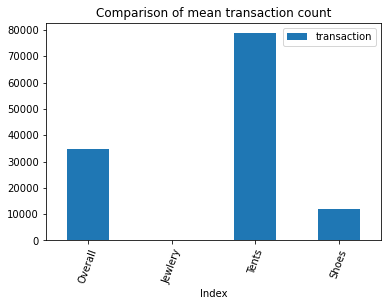

In [30]:
data_transaction = {'transaction':  [transaction_overall,transaction_jewlery,transaction_tents,transaction_shoes],
                    "Index":["Overall", "Jewlery", "Tents", "Shoes"]  
        }
df_transaction = pd.DataFrame(data_transaction)
df_transaction.plot.bar(x="Index", y="transaction", rot=70, title="Comparison of mean transaction count")



In [29]:
# Next see the comparison of total revenue mean
revenue_overall = top_n_merchant['total_revenue'].mean()
revenue_jewlery = top_10_merchant_jewlery_designed['total_revenue'].mean()
revenue_tents = top_10_merchant_tents_designed['total_revenue'].mean()
revenue_shoes = top_10_merchant_shoe_designed['total_revenue'].mean()

<AxesSubplot:title={'center':'Comparison of mean merchant revenue'}, xlabel='Index'>

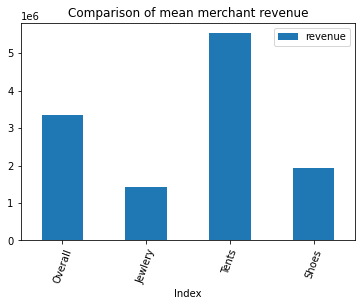

In [31]:
data_revnue = {'revenue':  [revenue_overall,revenue_jewlery,revenue_tents,revenue_shoes],
                    "Index":["Overall", "Jewlery", "Tents", "Shoes"]  
        }
df_revenue = pd.DataFrame(data_revnue)
df_revenue.plot.bar(x="Index", y="revenue", rot=70, title="Comparison of mean merchant revenue")

In [37]:
# BNPL earnings comparison per order
takerate_overall = top_n_merchant['take_rate'].mean()
takerate_jewlery = top_10_merchant_jewlery_designed['take_rate'].mean()
takerate_tents = top_10_merchant_tents_designed['take_rate'].mean()
takerate_shoes = top_10_merchant_shoe_designed['take_rate'].mean()


# Calculate BNPL firm earning
BNPL_overall = (revenue_overall / transaction_overall) * (0.01*takerate_overall)
BNPL_jewlery = (revenue_jewlery / transaction_jewlery) * (0.01*takerate_jewlery)
BNPL_tents = (revenue_tents / transaction_tents) * (0.01*takerate_tents)
BNPL_shoes = (revenue_shoes / transaction_shoes) * (0.01*takerate_shoes)


<AxesSubplot:title={'center':'Comparison of BNPL earnings per transaction'}, xlabel='Index'>

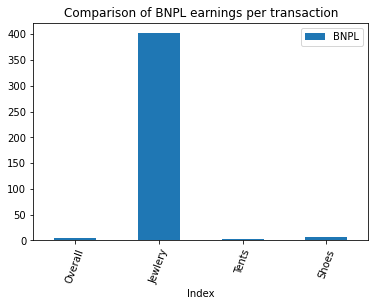

In [38]:
data_BNPL= {'BNPL':  [BNPL_overall,BNPL_jewlery,BNPL_tents,BNPL_shoes],
                    "Index":["Overall", "Jewlery", "Tents", "Shoes"]  
        }
df_BNPL = pd.DataFrame(data_BNPL)
df_BNPL.plot.bar(x="Index", y="BNPL", rot=70, title="Comparison of BNPL earnings per transaction")

In [36]:
takerate_jewlery

4.3050000000000015